In [1]:
!pip install timm

In [2]:
import os
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2

from sklearn.model_selection import train_test_split
from sklearn import metrics

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from tqdm.notebook import tqdm
import albumentations as A

import timm

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


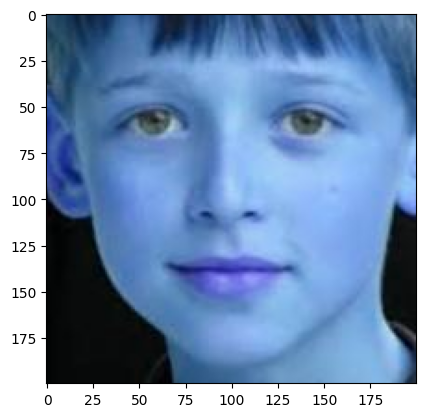

In [3]:
img = cv2.imread("/kaggle/input/utkface-new/UTKFace/10_0_0_20161220222308131.jpg.chip.jpg")
img.shape
plt.imshow(img)

In [4]:
cars = os.listdir("/kaggle/input/utkface-new")
cars = sorted(cars)
cars[:10]

['UTKFace', 'crop_part1', 'utkface_aligned_cropped']

In [5]:
cars = glob("/kaggle/input/utkface-new/*/*")
cars = sorted(cars)
cars[:10]

['/kaggle/input/utkface-new/UTKFace/100_0_0_20170112213500903.jpg.chip.jpg',
 '/kaggle/input/utkface-new/UTKFace/100_0_0_20170112215240346.jpg.chip.jpg',
 '/kaggle/input/utkface-new/UTKFace/100_1_0_20170110183726390.jpg.chip.jpg',
 '/kaggle/input/utkface-new/UTKFace/100_1_0_20170112213001988.jpg.chip.jpg',
 '/kaggle/input/utkface-new/UTKFace/100_1_0_20170112213303693.jpg.chip.jpg',
 '/kaggle/input/utkface-new/UTKFace/100_1_0_20170112215032192.jpg.chip.jpg',
 '/kaggle/input/utkface-new/UTKFace/100_1_0_20170117195420803.jpg.chip.jpg',
 '/kaggle/input/utkface-new/UTKFace/100_1_0_20170119212053665.jpg.chip.jpg',
 '/kaggle/input/utkface-new/UTKFace/100_1_2_20170105174847679.jpg.chip.jpg',
 '/kaggle/input/utkface-new/UTKFace/100_1_2_20170112213615815.jpg.chip.jpg']

In [6]:
# from os import walk
# for (dirpath, dirnames, filenames) in walk("../input/"):
#     print("Directory path: ", dirpath)
#     print("Folder name: ", dirnames)
# #     print("File name: ", filenames)

In [7]:
def label_images_train(img_path):
    labeled_data = {}
    filename = img_path.split('/')
    filename_ = filename[len(filename)-1]
    #for filename in os.listdir(directory):
    dot_split = filename_.split('.')
    # Split the filename based on underscores
    parts = dot_split[0].split('_')

    # Extract gender and age information
    gender_ = int(parts[1])
    age_ = int(parts[0]) 

    # Append the labeled information to the list
    labeled_data["filename"] = filename_
    labeled_data["gender"] = gender_
    labeled_data["age"] = age_
    
    return labeled_data

In [8]:
label_images_train("/kaggle/input/utkface-new/UTKFace/100_1_0_20170110183726390.jpg.chip.jpg")

{'filename': '100_1_0_20170110183726390.jpg.chip.jpg', 'gender': 1, 'age': 100}

In [9]:
Xg = []
yg = []
Xa = []
ya = []

In [10]:
paths = glob("/kaggle/input/utkface-new/UTKFace/*")
path = sorted(paths)
for path in paths:
    Xg.append(path)
    Xa.append(path)
    yg.append(label_images_train(path)["gender"])    
    ya.append(label_images_train(path)["age"])  

In [11]:
len(yg)

23708

(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)


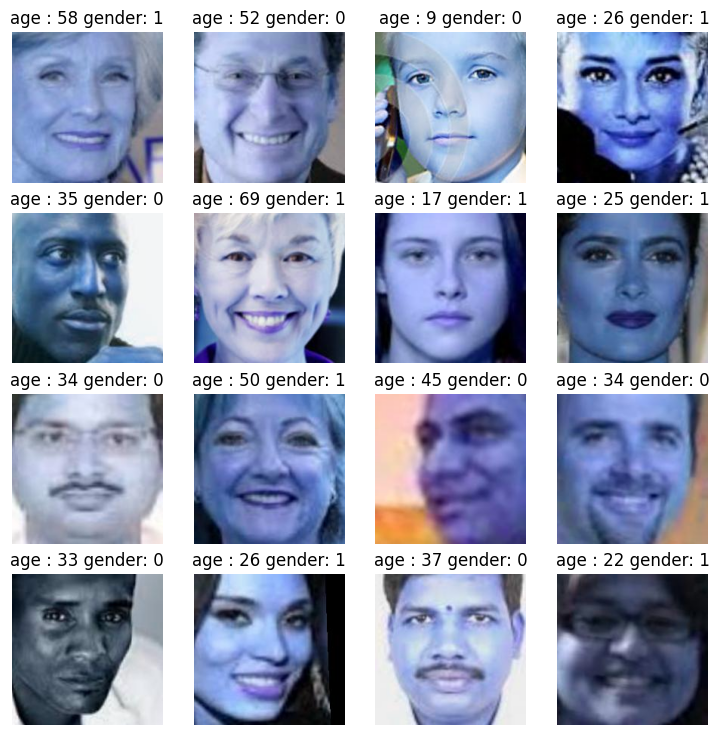

In [12]:
# Plot more images
#torch.manual_seed(4)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(Xa), size=[1]).item()
    img = cv2.imread(Xa[random_idx])
    age, gender = ya[random_idx], yg[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img)
    plt.title("age : %s gender: %s"%(age,gender))
    plt.axis(False)
    print(img.shape)

In [13]:
class NaturalDataset_a(Dataset):

    # constructor
    def __init__(self, train = True):

        super().__init__()

        # initialize lists to store paths of images and their corresponding labels
        self.image_paths = []
        self.labels = []

        for i in range (len(Xa)):
                self.image_paths.append(Xa[i])
                self.labels.append(ya[i])

        # train_test_split (random state has to be fixed to maintain the same split)
        image_train, image_val, label_train, label_val = train_test_split(self.image_paths, self.labels, shuffle=True, test_size = 0.2, random_state=2000)

        if train:
            self.image_paths = image_train
            self.labels = label_train
        else:
            self.image_paths = image_val
            self.labels = label_val

        # function for augumentation and preprocessing
        self.transform = A.Compose([
            A.Resize(128, 128),
            A.HorizontalFlip(),
            A.RandomBrightnessContrast(p=0.5),
        ])


    # len function
    def __len__(self):
        return len(self.image_paths)


    # function to return the pair (image, label)
    def __getitem__(self, idx):

        # read image
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        img = img[:, :, ::-1]

        # applying preprocessing and augumentation
        transformed = self.transform(image = img)
        img = transformed['image']
        
        # making the required shape of the image
        img = img.transpose(2, 0, 1)

        # image tensor
        img_tensor = torch.tensor(img, dtype=torch.float)/255

        # label tensor
        label = self.labels[idx]
        label_tensor = torch.tensor(label, dtype=torch.long)

        return img_tensor, label_tensor

In [14]:
class NaturalDataset_g(Dataset):

    # constructor
    def __init__(self, train = True):

        super().__init__()

        # initialize lists to store paths of images and their corresponding labels
        self.image_paths = []
        self.labels = []

        for i in range (len(Xg)):
                self.image_paths.append(Xg[i])
                self.labels.append(yg[i])

        # train_test_split (random state has to be fixed to maintain the same split)
        image_train, image_val, label_train, label_val = train_test_split(self.image_paths, self.labels, shuffle=True, test_size = 0.2, random_state=2000)

        if train:
            self.image_paths = image_train
            self.labels = label_train
        else:
            self.image_paths = image_val
            self.labels = label_val

        # function for augumentation and preprocessing
        self.transform = A.Compose([
            A.Resize(128, 128),
            A.HorizontalFlip(),
            A.RandomBrightnessContrast(p=0.5),
        ])


    # len function
    def __len__(self):
        return len(self.image_paths)


    # function to return the pair (image, label)
    def __getitem__(self, idx):

        # read image
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        img = img[:, :, ::-1]

        # applying preprocessing and augumentation
        transformed = self.transform(image = img)
        img = transformed['image']
        
        # making the required shape of the image
        img = img.transpose(2, 0, 1)

        # image tensor
        img_tensor = torch.tensor(img, dtype=torch.float)/255

        # label tensor
        label = self.labels[idx]
        label_tensor = torch.tensor(label, dtype=torch.long)

        return img_tensor, label_tensor

In [15]:
obj_a = NaturalDataset_a()
obj_g = NaturalDataset_g()

32


(3, 128, 128)

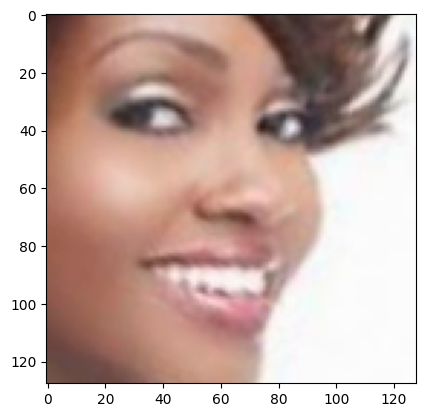

In [16]:
idx = 44
img_label_pair = obj_a[idx]
img = img_label_pair[0]
label = img_label_pair[1].item()
img = img.numpy()
plt.imshow(img.transpose(1, 2, 0))
print(label)
img.shape

In [17]:
train_dataset_a = NaturalDataset_a(train=True)
train_loader_a = DataLoader(train_dataset_a,
                          batch_size = 16,
                          num_workers = 2,
                          drop_last = True,
                          shuffle = True)

In [18]:
val_dataset_a = NaturalDataset_a(train=False)
val_loader_a = DataLoader(val_dataset_a,
                          batch_size = 16,
                          num_workers = 2,
                          drop_last = False,
                          shuffle = False)

In [19]:
len(train_loader_a)
len(val_loader_a)

297

In [20]:
train_dataset_g = NaturalDataset_g(train=True)
train_loader_g = DataLoader(train_dataset_g,
                          batch_size = 16,
                          num_workers = 2,
                          drop_last = True,
                          shuffle = True)

In [21]:
val_dataset_g = NaturalDataset_g(train=False)
val_loader_g = DataLoader(val_dataset_g,
                          batch_size = 16,
                          num_workers = 2,
                          drop_last = False,
                          shuffle = False)

In [22]:
img_new = cv2.imread("/kaggle/input/utkface-new/UTKFace/100_0_0_20170112215240346.jpg.chip.jpg")
img_new.shape

(200, 200, 3)

In [23]:
len(train_loader_a)
len(val_loader_a)

297

In [24]:
class NaturalModel_g(nn.Module):

    # initalize all the required layers
    def __init__(self, num_classes = 2):
        super().__init__()

        # initializing convolution layers
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 10, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(10)

        self.conv2 = nn.Conv2d(in_channels = 10, out_channels = 20, kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.BatchNorm2d(20)

        self.conv3 = nn.Conv2d(in_channels = 20, out_channels = 40, kernel_size=3, stride=1, padding=1)
        self.norm3 = nn.BatchNorm2d(40)

        # initializing linear layers
        self.linear1 = nn.Linear(40*16*16, 100)
        self.linear2 = nn.Linear(100, num_classes)

        # pooling function
        self.pool = nn.MaxPool2d(2, 2)

        # activation function
        self.relu = nn.ReLU()

        # dropout function
        self.dropout = nn.Dropout(0.2)

        # softmax function
        self.Sigmoid = nn.Sigmoid()


    # function for passing the input image through the layers
    def forward(self, x):

        # shape: (batch size, number of channels, height, width)

        # input shape: (16, 3, 128, 128)

        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)

        x = self.pool(x)
        # shape: (16, 10, 64, 64)

        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu(x)

        x = self.pool(x)
        # shape: (16, 20, 32, 32)

        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu(x)

        x = self.pool(x)
        # shape: (16, 40, 16, 16)

        x = x.view(-1, 40*16*16)
        x = self.dropout(x)
        # shape: (16, 40*16*16)

        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        # shape: (16, 100)

        x = self.linear2(x)
        # shape: (16, 8)


        return x

In [25]:
class NaturalModel_a(nn.Module):

    # initalize all the required layers
    def __init__(self, num_classes = 1):
        super().__init__()

        # initializing convolution layers
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 10, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(10)

        self.conv2 = nn.Conv2d(in_channels = 10, out_channels = 20, kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.BatchNorm2d(20)

        self.conv3 = nn.Conv2d(in_channels = 20, out_channels = 40, kernel_size=3, stride=1, padding=1)
        self.norm3 = nn.BatchNorm2d(40)

        # initializing linear layers
        self.linear1 = nn.Linear(40*16*16, 100)
        self.linear2 = nn.Linear(100, num_classes)

        # pooling function
        self.pool = nn.MaxPool2d(2, 2)

        # activation function
        self.relu = nn.ReLU()

        # dropout function
        self.dropout = nn.Dropout(0.2)

    # function for passing the input image through the layers
    def forward(self, x):

        # shape: (batch size, number of channels, height, width)

        # input shape: (16, 3, 128, 128)

        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)

        x = self.pool(x)
        # shape: (16, 10, 64, 64)

        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu(x)

        x = self.pool(x)
        # shape: (16, 20, 32, 32)

        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu(x)

        x = self.pool(x)
        # shape: (16, 40, 16, 16)

        x = x.view(-1, 40*16*16)
        x = self.dropout(x)
        # shape: (16, 40*16*16)

        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        # shape: (16, 100)

        x = self.linear2(x)
        # shape: (16, 1)


        return x

In [26]:
model_g = NaturalModel_g()
model_a = NaturalModel_a()

In [27]:
batch_g = torch.rand((16, 3, 128, 128))
model_g(batch_g).shape
batch_a = torch.rand((16, 3, 128, 128))
model_a(batch_g).shape

torch.Size([16, 1])

In [28]:
model_g.to(DEVICE)
model_a.to(DEVICE)

NaturalModel_a(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=10240, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=1, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [29]:
# loss function
criterion_g = nn.CrossEntropyLoss()

# optimization technique
optimizer_g = torch.optim.Adam(model_g.parameters(), lr = 0.001)
# loss function
criterion_a = nn.MSELoss()

# optimization technique
optimizer_a = torch.optim.Adam(model_a.parameters(), lr = 0.001)

In [30]:
def train_fn_a(train_loader, model, criterion, optimizer):

    # list to store the loss calculated on each batch
    losses = []

    # to enable batchnorm, dropout etc.
    model.train()

    progress = tqdm(train_loader, total=len(train_loader))

    for i, (imgs, labels) in enumerate(progress):

        # image and label tensors should be on the same device
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward Propogation and calculation of loss
        y_preds = model(imgs)
        y_preds = y_preds.to(torch.float32)
        labels = labels.to(torch.float32)
        y_preds = y_preds.squeeze()
        loss = criterion(y_preds, labels)

        # Back Propogation
        optimizer.zero_grad()         # Clearing all previous gradients, setting them to zero
        loss.backward()               # Calculating the new gradients (backprop)
        optimizer.step()              # Updating the weights using the gradients

        # appending the loss to the list
        losses.append(loss.item())

    # returning the mean loss over the epoch
    return np.mean(losses)

In [31]:
def train_fn_g(train_loader, model, criterion, optimizer):

    # list to store the loss calculated on each batch
    losses = []

    # to enable batchnorm, dropout etc.
    model.train()

    progress = tqdm(train_loader, total=len(train_loader))

    for i, (imgs, labels) in enumerate(progress):

        # image and label tensors should be on the same device
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward Propogation and calculation of loss
        y_preds = model(imgs)
        loss = criterion(y_preds, labels)

        # Back Propogation
        optimizer.zero_grad()         # Clearing all previous gradients, setting them to zero
        loss.backward()               # Calculating the new gradients (backprop)
        optimizer.step()              # Updating the weights using the gradients

        # appending the loss to the list
        losses.append(loss.item())

    # returning the mean loss over the epoch
    return np.mean(losses)

In [32]:
def val_fn_a(val_loader, model, criterion, optimizer):

    # list to store the loss calculated on each batch
    losses = []

    # to disable batchnorm, dropout etc.
    model.eval()

    progress = tqdm(val_loader, total=len(val_loader))

    for i, (imgs, labels) in enumerate(progress):

        # image and label tensors should be on the same device as that of model
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        # to disable the calculation of gradients
        with torch.no_grad():

            # Forward Propogation and calculation of loss
            y_preds = model(imgs)
            y_preds = y_preds.to(torch.float32)
            labels = labels.to(torch.float32)
            y_preds = y_preds.squeeze()
            loss = criterion(y_preds, labels)

        # appending the loss to the list
        losses.append(loss.item())

    # returning the mean loss over the epoch
    return np.mean(losses)

In [33]:
def val_fn_g(val_loader, model, criterion, optimizer):

    # list to store the loss calculated on each batch
    losses = []

    # to disable batchnorm, dropout etc.
    model.eval()

    progress = tqdm(val_loader, total=len(val_loader))

    for i, (imgs, labels) in enumerate(progress):

        # image and label tensors should be on the same device as that of model
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        # to disable the calculation of gradients
        with torch.no_grad():

            # Forward Propogation and calculation of loss
            y_preds = model(imgs)
            loss = criterion(y_preds, labels)

        # appending the loss to the list
        losses.append(loss.item())

    # returning the mean loss over the epoch
    return np.mean(losses)

In [34]:
EPOCHS = 10

# list to store the loss of each epoch
train_losses_a = []
val_losses_a = []

# for storing the best weights of the model
best_dict_a = None
best_loss_a = np.inf

for ep in range(EPOCHS):

    print('='*5 + f" Epoch {ep+1} " + '='*5)

    # training and validation loop
    tr_loss_a = train_fn_a(train_loader_a, model_a, criterion_a, optimizer_a)
    val_loss_a = val_fn_a(val_loader_a, model_a, criterion_a, optimizer_a)

    # updating the best weights, if loss is even less than the best one
    if val_loss_a < best_loss_a:
        best_loss_a = val_loss_a
        best_dict_a = model_a.state_dict()

    # appending the loss of each epoch
    train_losses_a.append(tr_loss_a)
    val_losses_a.append(val_loss_a)

    print(f"Epoch {ep} - Train Loss {tr_loss_a:.4f} - Val Loss {val_loss_a:.4f}\n")

===== Epoch 1 =====


  0%|          | 0/1185 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

Epoch 0 - Train Loss 205.8404 - Val Loss 143.3357

===== Epoch 2 =====


  0%|          | 0/1185 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

Epoch 1 - Train Loss 142.9972 - Val Loss 125.2520

===== Epoch 3 =====


  0%|          | 0/1185 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

Epoch 2 - Train Loss 130.1267 - Val Loss 120.8129

===== Epoch 4 =====


  0%|          | 0/1185 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

Epoch 3 - Train Loss 117.9244 - Val Loss 131.3854

===== Epoch 5 =====


  0%|          | 0/1185 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

Epoch 4 - Train Loss 110.3656 - Val Loss 115.0827

===== Epoch 6 =====


  0%|          | 0/1185 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

Epoch 5 - Train Loss 106.8679 - Val Loss 97.0947

===== Epoch 7 =====


  0%|          | 0/1185 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

Epoch 6 - Train Loss 100.7379 - Val Loss 97.7793

===== Epoch 8 =====


  0%|          | 0/1185 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

Epoch 7 - Train Loss 97.8095 - Val Loss 116.0746

===== Epoch 9 =====


  0%|          | 0/1185 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

Epoch 8 - Train Loss 95.8404 - Val Loss 101.2388

===== Epoch 10 =====


  0%|          | 0/1185 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

Epoch 9 - Train Loss 93.3744 - Val Loss 85.0055



In [35]:
EPOCHS = 10

# list to store the loss of each epoch
train_losses_g = []
val_losses_g = []

# for storing the best weights of the model
best_dict_g = None
best_loss_g = np.inf

for ep in range(EPOCHS):

    print('='*5 + f" Epoch {ep+1} " + '='*5)

    # training and validation loop
    tr_loss_g = train_fn_g(train_loader_g, model_g, criterion_g, optimizer_g)
    val_loss_g = val_fn_g(val_loader_g, model_g, criterion_g, optimizer_g)

    # updating the best weights, if loss is even less than the best one
    if val_loss_g < best_loss_g:
        best_loss_g = val_loss_g
        best_dict_g = model_g.state_dict()

    # appending the loss of each epoch
    train_losses_g.append(tr_loss_g)
    val_losses_g.append(val_loss_g)

    print(f"Epoch {ep} - Train Loss {tr_loss_g:.4f} - Val Loss {val_loss_g:.4f}\n")

===== Epoch 1 =====


  0%|          | 0/1185 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

Epoch 0 - Train Loss 0.4022 - Val Loss 0.3360

===== Epoch 2 =====


  0%|          | 0/1185 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

Epoch 1 - Train Loss 0.3032 - Val Loss 0.3130

===== Epoch 3 =====


  0%|          | 0/1185 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

Epoch 2 - Train Loss 0.2773 - Val Loss 0.2847

===== Epoch 4 =====


  0%|          | 0/1185 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

Epoch 3 - Train Loss 0.2570 - Val Loss 0.2593

===== Epoch 5 =====


  0%|          | 0/1185 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

Epoch 4 - Train Loss 0.2393 - Val Loss 0.2795

===== Epoch 6 =====


  0%|          | 0/1185 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

Epoch 5 - Train Loss 0.2319 - Val Loss 0.2485

===== Epoch 7 =====


  0%|          | 0/1185 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

Epoch 6 - Train Loss 0.2185 - Val Loss 0.2449

===== Epoch 8 =====


  0%|          | 0/1185 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

Epoch 7 - Train Loss 0.2131 - Val Loss 0.2478

===== Epoch 9 =====


  0%|          | 0/1185 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

Epoch 8 - Train Loss 0.2068 - Val Loss 0.2376

===== Epoch 10 =====


  0%|          | 0/1185 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

Epoch 9 - Train Loss 0.2005 - Val Loss 0.2432



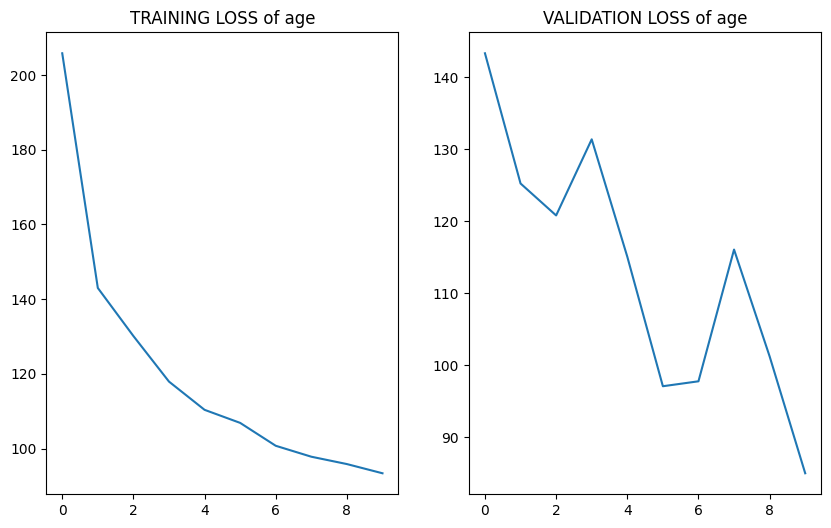

In [36]:
plt.figure(figsize=(10, 6))

plt.subplot(1,2,1)
plt.title("TRAINING LOSS of age")
plt.plot(train_losses_a)

plt.subplot(1,2,2)
plt.title("VALIDATION LOSS of age")
plt.plot(val_losses_a)

plt.show()

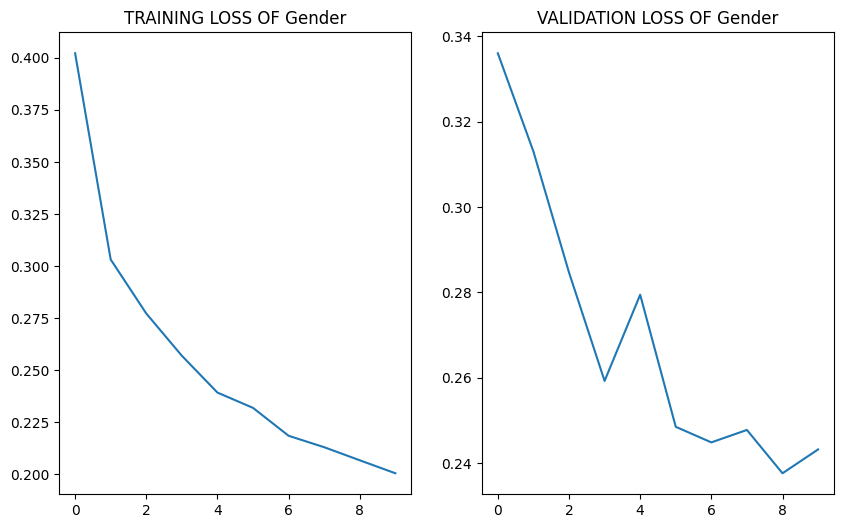

In [37]:
plt.figure(figsize=(10, 6))

plt.subplot(1,2,1)
plt.title("TRAINING LOSS OF Gender")
plt.plot(train_losses_g)

plt.subplot(1,2,2)
plt.title("VALIDATION LOSS OF Gender")
plt.plot(val_losses_g)

plt.show()

In [38]:
# loading the best weights of model
model_a.load_state_dict(best_dict_a)

<All keys matched successfully>

In [39]:
# loading the best weights of model
model_g.load_state_dict(best_dict_g)

<All keys matched successfully>

In [40]:
# list to store predicted and the true labels
val_preds_a = []
val_trues_a = []

# prediction on validation dataset
progress = tqdm(val_loader_a, total=len(val_loader_a))

# to disable batchnorm, dropout etc.
model_a.eval()

for i, (imgs, labels) in enumerate(progress):

    # image and label tensors should be on the same device as that of model
    imgs = imgs.to(DEVICE)
    labels = labels.to(DEVICE)

    # forward propogation
    with torch.no_grad():
        y_preds_a = model_a(imgs)

    # taking the label with max score as the predicted label
    # y_preds shape: (16, 8)
    # pred_labels shape: (16, 1)
    pred_labels = y_preds_a
    # appending the predicted and true labels to the corresponding lists
    val_preds_a.extend(pred_labels.tolist())
    val_trues_a.extend(labels.cpu().numpy().tolist())

  0%|          | 0/297 [00:00<?, ?it/s]

In [41]:
# list to store predicted and the true labels
val_preds_g = []
val_trues_g = []

# prediction on validation dataset
progress = tqdm(val_loader_g, total=len(val_loader_g))

# to disable batchnorm, dropout etc.
model_g.eval()

for i, (imgs, labels) in enumerate(progress):

    # image and label tensors should be on the same device as that of model
    imgs = imgs.to(DEVICE)
    labels = labels.to(DEVICE)

    # forward propogation
    with torch.no_grad():
        y_preds_g = model_g(imgs)

    # taking the label with max score as the predicted label
    # y_preds shape: (16, 8)
    # pred_labels shape: (16, 1)
    pred_labels = np.argmax(y_preds_g.cpu().numpy(), axis=1)

    # appending the predicted and true labels to the corresponding lists
    val_preds_g.extend(pred_labels.tolist())
    val_trues_g.extend(labels.cpu().numpy().tolist())

  0%|          | 0/297 [00:00<?, ?it/s]

In [42]:
val_trues_a[:10],val_preds_a[:10]

([80, 35, 61, 68, 34, 49, 16, 8, 29, 42],
 [[75.6505355834961],
  [33.0307731628418],
  [75.82563018798828],
  [66.26522827148438],
  [33.36967849731445],
  [49.16133117675781],
  [22.45760154724121],
  [11.496856689453125],
  [26.274837493896484],
  [52.756229400634766]])

In [43]:
metrics.r2_score(val_trues_a,val_preds_a)

0.7925483952106533

In [44]:
metrics.accuracy_score(val_preds_g, val_trues_g)

0.8956136651202025

In [45]:
img_k_ = cv2.imread("/kaggle/input/kanishk4/WhatsApp Image 2023-12-31 at 3.46.47 PM.jpeg")
img_k = cv2.resize(img_k_, (128, 128))
img_k = img_k[:,:,::-1]
img_k = img_k.transpose((2,0,1)).copy()
img_c_ = cv2.imread("/kaggle/input/kanishk4/WhatsApp Image 2023-12-31 at 3.46.47 PM.jpeg")
img_c = cv2.resize(img_c_, (128, 128))
img_c = img_c[:,:,::-1]
img_c = img_c.transpose((2,0,1)).copy()

In [46]:
img_k_tensor = torch.tensor(img_k, dtype=torch.float)/255
img_k_tensor = img_k_tensor.unsqueeze(0).type(torch.cuda.FloatTensor)
img_c_tensor = torch.tensor(img_c, dtype=torch.float)/255
img_c_tensor = img_c_tensor.unsqueeze(0).type(torch.cuda.FloatTensor)

In [47]:
age_k = model_a(img_k_tensor).round()
gender_k = np.argmax(model_g(img_k_tensor).cpu().detach().numpy())
if(gender_k == 0):
    gender_k = "Male"
else:
    gender_k = "Female"
age_c = model_a(img_c_tensor).round()
gender_c = np.argmax(model_g(img_c_tensor).cpu().detach().numpy())
if(gender_c == 0):
    gender_c = "Male"
else:
    gender_c = "Female"

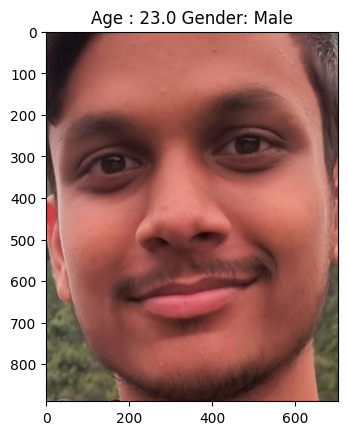

In [48]:
plt.title("Age : %s Gender: %s"%(age_k.item(),gender_k))
plt.imshow(img_k_[:,:,::-1])
